In [1]:
#importing requir
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time


In [2]:
def fetch_crypto_data():
    # Define the API endpoint to fetch cryptocurrency data
    url = "https://api.coincap.io/v2/assets"
    
    # Send a GET request to the API endpoint
    response = requests.get(url)

    # Check if the request was successful (status code 200 means success)
    if response.status_code == 200:
        # Parse the response JSON data
        data = response.json()
        
        # Access the 'data' field which contains a list of cryptocurrencies
        assets = data['data']
        
        # Create an empty list to store currency information
        currency_data = []
        
        # Loop through each asset and extract the symbol and price in USD
        for asset in assets:
            currency_data.append({
                'Currency': asset['symbol'],   # Currency symbol (e.g., BTC, ETH)
                'Rate': asset['priceUsd']      # Current price in USD
            })

        # Convert the list of currency data into a DataFrame for better display
        rates_df = pd.DataFrame(currency_data)
        
        # Print the current cryptocurrency rates
        print("Current Cryptocurrency Rates:\n", rates_df)
    else:
        # If the request failed, print the status code
        print(f"API request failed with status code: {response.status_code}")


In [3]:
import requests
import pandas as pd
import time

def fetch_historical_crypto_data(asset_id, start, end, interval):
    # Construct the API endpoint URL using the provided parameters
    url = f"https://api.coincap.io/v2/assets/{asset_id}/history?interval={interval}&start={start}&end={end}"
    
    # Send a GET request to the API endpoint
    response = requests.get(url)
    
    # Check if the request was successful (status code 200 indicates success)
    if response.status_code == 200:
        # Parse the response JSON data
        data = response.json()
        
        # Extract the 'data' field containing the historical cryptocurrency data
        historical_data = data['data']

        # Check if there is any historical data available
        if not historical_data:
            print("No historical data found.")
            return None

        # Convert the list of historical data into a DataFrame
        historical_df = pd.DataFrame(historical_data)

        # Check if the 'priceUsd' column is present and rename it to 'close' if it exists
        if 'priceUsd' in historical_df.columns:
            historical_df.rename(columns={'priceUsd': 'close'}, inplace=True)
        
        # Attempt to extract 'open', 'high', and 'low' prices if these columns are available
        # Note: Replace with the actual keys if the API response contains different field names
        historical_df['open'] = historical_df.get('open', None)  # Use the 'open' field if present
        historical_df['high'] = historical_df.get('high', None)  # Use the 'high' field if present
        historical_df['low'] = historical_df.get('low', None)    # Use the 'low' field if present

        # Convert the 'date' column to a datetime format for better data handling
        historical_df['date'] = pd.to_datetime(historical_df['date'])

        # Reorder the DataFrame columns to maintain a consistent structure
        historical_df = historical_df[['date', 'open', 'high', 'low', 'close']]

        # Return the DataFrame containing the cleaned and formatted historical data
        return historical_df
    else:
        # If the request failed, print the status code for debugging purposes
        print(f"API request failed with status code: {response.status_code}")
        return None

# Example usage
end = int(time.time() * 1000)  # Get the current time in milliseconds
start = end - (30 * 24 * 60 * 60 * 1000)  # Calculate the timestamp for 30 days ago in milliseconds

# Fetch historical data for Bitcoin with a daily ('d1') interval
historical_df = fetch_historical_crypto_data('bitcoin', start, end, 'd1')

# Check if the data was fetched successfully and display the first few rows
if historical_df is not None:
    print(historical_df.head())
else:
    print("Failed to fetch historical data.")


                       date  open  high   low                   close
0 2024-09-29 00:00:00+00:00  None  None  None  65625.4284752638926580
1 2024-09-30 00:00:00+00:00  None  None  None  64041.0202988942189779
2 2024-10-01 00:00:00+00:00  None  None  None  62855.0590319571732252
3 2024-10-02 00:00:00+00:00  None  None  None  61286.4660792812331127
4 2024-10-03 00:00:00+00:00  None  None  None  60808.3492710690839442


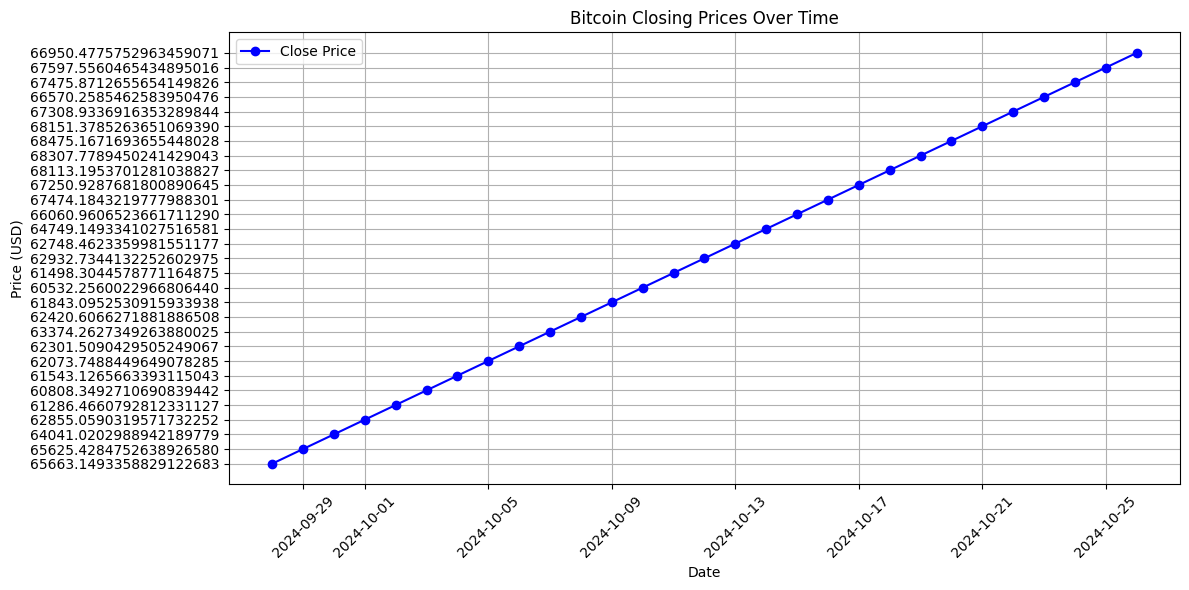

In [40]:
import matplotlib.pyplot as plt

# Ensure the date column is in datetime format
historical_df['date'] = pd.to_datetime(historical_df['date'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(historical_df['date'], historical_df['close'], marker='o', label='Close Price', color='blue')
plt.title('Bitcoin Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd

def calculate_metrics(data: pd.DataFrame, variable1: int, variable2: int) -> pd.DataFrame:
    # Calculate the highest price over the last 'variable1' days using a rolling window
    data[f'High_Last_{variable1}_Days'] = data['High'].rolling(window=variable1).max()
    
    # Calculate the index of the highest price in the last 'variable1' days
    high_last_idx = data['High'].rolling(window=variable1).apply(lambda x: x.idxmax(), raw=False)
    # Remove NaN values to ensure valid indexing
    valid_high_idx = high_last_idx.dropna().astype(int)
    
    # Calculate the number of days since the last highest price in the last 'variable1' days
    data[f'Days_Since_High_Last_{variable1}_Days'] = pd.Series(
        (data['Date'] - data['Date'].iloc[valid_high_idx]).dt.days,
        index=valid_high_idx
    ).reindex(data.index)  # Reindex to align with the original DataFrame's index

    # Calculate the percentage difference between the current close price and the highest price in the last 'variable1' days
    data[f'%_Diff_From_High_Last_{variable1}_Days'] = ((data['Close'] - data[f'High_Last_{variable1}_Days']) / data[f'High_Last_{variable1}_Days']) * 100

    # Calculate the lowest price over the last 'variable1' days using a rolling window
    data[f'Low_Last_{variable1}_Days'] = data['Low'].rolling(window=variable1).min()
    
    # Calculate the index of the lowest price in the last 'variable1' days
    low_last_idx = data['Low'].rolling(window=variable1).apply(lambda x: x.idxmin(), raw=False)
    # Remove NaN values to ensure valid indexing
    valid_low_idx = low_last_idx.dropna().astype(int)
    
    # Calculate the number of days since the last lowest price in the last 'variable1' days
    data[f'Days_Since_Low_Last_{variable1}_Days'] = pd.Series(
        (data['Date'] - data['Date'].iloc[valid_low_idx]).dt.days,
        index=valid_low_idx
    ).reindex(data.index)  # Reindex to align with the original DataFrame's index

    # Calculate the percentage difference between the current close price and the lowest price in the last 'variable1' days
    data[f'%_Diff_From_Low_Last_{variable1}_Days'] = ((data['Close'] - data[f'Low_Last_{variable1}_Days']) / data[f'Low_Last_{variable1}_Days']) * 100

    # Calculate the highest price over the next 'variable2' days using a rolling window
    data[f'High_Next_{variable2}_Days'] = data['High'].shift(-variable2).rolling(window=variable2).max()

    # Calculate the percentage difference between the current close price and the highest price in the next 'variable2' days
    data[f'%_Diff_From_High_Next_{variable2}_Days'] = ((data['Close'] - data[f'High_Next_{variable2}_Days']) / data[f'High_Next_{variable2}_Days']) * 100

    # Calculate the lowest price over the next 'variable2' days using a rolling window
    data[f'Low_Next_{variable2}_Days'] = data['Low'].shift(-variable2).rolling(window=variable2).min()

    # Calculate the percentage difference between the current close price and the lowest price in the next 'variable2' days
    data[f'%_Diff_From_Low_Next_{variable2}_Days'] = ((data['Close'] - data[f'Low_Next_{variable2}_Days']) / data[f'Low_Next_{variable2}_Days']) * 100

    return data

# Example usage
data = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-01', periods=100),  # Generate a range of dates
    'High': pd.Series(range(100)) + 10,  # Sample high prices
    'Low': pd.Series(range(100)),        # Sample low prices
    'Close': pd.Series(range(50, 150))   # Sample close prices
})

# Calculate metrics using a rolling window of 5 days for past data and 3 days for future data
result = calculate_metrics(data, variable1=5, variable2=3)

# Display the last few rows of the result to verify the calculations
print(result.tail())


         Date  High  Low  Close  High_Last_5_Days  \
95 2023-04-06   105   95    145             105.0   
96 2023-04-07   106   96    146             106.0   
97 2023-04-08   107   97    147             107.0   
98 2023-04-09   108   98    148             108.0   
99 2023-04-10   109   99    149             109.0   

    Days_Since_High_Last_5_Days  %_Diff_From_High_Last_5_Days  \
95                          0.0                     38.095238   
96                          0.0                     37.735849   
97                          0.0                     37.383178   
98                          0.0                     37.037037   
99                          0.0                     36.697248   

    Low_Last_5_Days  Days_Since_Low_Last_5_Days  %_Diff_From_Low_Last_5_Days  \
95             91.0                         0.0                    59.340659   
96             92.0                         NaN                    58.695652   
97             93.0                         NaN   

In [5]:
import pandas as pd

# Sample data for January 2024
data = {
    'Date': pd.date_range(start='2024-01-01', periods=8, freq='D'),
    'Open': [50000, 50500, 51500, 52500, 53000, 53500, 54000, 54500],
    'High': [51000, 52000, 53000, 53500, 54000, 54500, 55000, 55500],
    'Low': [49500, 50000, 50500, 51000, 51500, 52000, 52500, 53000],
    'Close': [50500, 51500, 52500, 53000, 53500, 54000, 54500, 55000]
}

df = pd.DataFrame(data)
print(df)


        Date   Open   High    Low  Close
0 2024-01-01  50000  51000  49500  50500
1 2024-01-02  50500  52000  50000  51500
2 2024-01-03  51500  53000  50500  52500
3 2024-01-04  52500  53500  51000  53000
4 2024-01-05  53000  54000  51500  53500
5 2024-01-06  53500  54500  52000  54000
6 2024-01-07  54000  55000  52500  54500
7 2024-01-08  54500  55500  53000  55000
